In [1]:
import shutil
import os
import pandas as pd

In [2]:
folder_path = "result_save/gnn_2025-03-14-18-49-10/GNNExplainer"

In [3]:
existing_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

In [4]:
allowed_idx=pd.read_csv('result_save\gnn_2025-03-14-18-49-10\GNNExplainer\most_importance_score_with_idx.csv')
allowed_idx_name=allowed_idx['idx'].values

In [5]:
allowed_folders_name=[f'node_{i}' for i in allowed_idx_name]

In [9]:
top_GO_BP=[]
top_KEGG=[]
def parse_gene_ratio(ratio):
    if isinstance(ratio, str) and '/' in ratio:
        num, denom = map(int, ratio.split('/'))
        return num / denom  # 计算比例
    return float(ratio)  # 可能已是 float 类型


In [7]:
for idx in allowed_idx_name[:]:

    # GO BP
    BP_file_path=f'{folder_path}/node_{idx}/enrich/GO_BP_{idx}.tsv'
    BP_file=pd.read_csv(BP_file_path,sep='\t')
    BP_file["GeneRatio_numeric"] = BP_file["GeneRatio"].apply(parse_gene_ratio)

    # 先按 GeneRatio_numeric 降序，再按 pvalue 升序排序
    BP_file_sorted = BP_file.sort_values(by=["GeneRatio_numeric", "pvalue"], ascending=[False, True])
    top_BP_pathway = BP_file_sorted.iloc[0]["Description"]  # 获取排名第一的通路名称
    top_GO_BP.append(top_BP_pathway)

    #KEGG
    KEGG_file_path=f'{folder_path}/node_{idx}/enrich/KEGG_{idx}.tsv'
    if not os.path.exists(KEGG_file_path):
        print(f"文件夹不存在: {KEGG_file_path}")
        top_KEGG.append('NaN')
        continue
    KEGG_file=pd.read_csv(KEGG_file_path,sep='\t')
    KEGG_file["GeneRatio_numeric"] = KEGG_file["GeneRatio"].apply(parse_gene_ratio)

    # 先按 GeneRatio_numeric 降序，再按 pvalue 升序排序
    KEGG_file_sorted = KEGG_file.sort_values(by=["GeneRatio_numeric", "pvalue"], ascending=[False, True])
    top_KEGG_pathway = KEGG_file_sorted.iloc[0]["Description"]  # 获取排名第一的通路名称
    top_KEGG.append(top_KEGG_pathway)
allowed_idx['top_BP_pathway']=top_GO_BP
allowed_idx['top_KEGG_pathway']=top_KEGG
print(allowed_idx)

FileNotFoundError: [Errno 2] No such file or directory: 'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_1056/enrich/GO_BP_1056.tsv'

In [ ]:
allowed_idx.to_csv(f'{folder_path}/sorce_with_enrich.csv',index=False)

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from gnn_explainer_layer import GNNExplainer_old
from gnn_data import GNN_DATA  
from gnn_models_sag import ppi_model,ppi_model_explain,ppi_model_got_embs
import numpy as np
import pandas as pd
import os
from draw_ppi import visualize_custom_subgraph,visualize_feature_importance,visualize_feature_importance_violin

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
os.environ['TORCH_USE_CUDA_DSA'] = '1' 

def multi2big_x(x_ori):
    x_cat = torch.zeros(1, 7)
    x_num_index = torch.zeros(1553)
    for i in range(1553):
        x_now = torch.tensor(x_ori[i])
        x_num_index[i] = torch.tensor(x_now.size(0))
        x_cat = torch.cat((x_cat, x_now), 0)
    return x_cat[1:, :], x_num_index

def multi2big_batch(x_num_index):
    num_sum = x_num_index.sum()
    num_sum = num_sum.int()
    batch = torch.zeros(num_sum)
    count = 1
    for i in range(1,1553):
        zj1 = x_num_index[:i]
        zj11 = zj1.sum()
        zj11 = zj11.int()
        zj22 = zj11 + x_num_index[i]
        zj22 = zj22.int()
        size1 = x_num_index[i]
        size1 = size1.int()
        tc = count * torch.ones(size1)
        batch[zj11:zj22] = tc
        test = batch[zj11:zj22]
        count = count + 1
    batch = batch.int()
    return batch

def multi2big_edge(edge_ori, num_index):
    edge_cat = torch.zeros(2, 1)
    edge_num_index = torch.zeros(1553)
    for i in range(1553):
        edge_index_p = edge_ori[i]
        edge_index_p = np.asarray(edge_index_p)
        edge_index_p = torch.tensor(edge_index_p.T)
        edge_num_index[i] = torch.tensor(edge_index_p.size(1))
        if i == 0:
            offset = 0
        else:
            zj = torch.tensor(num_index[:i])
            offset = zj.sum()
        edge_cat = torch.cat((edge_cat, edge_index_p + offset), 1)
    return edge_cat[:, 1:], edge_num_index


ppi_path = "./protein_info/protein.actions.SHS27k.STRING.pro2.txt"
pseq_path = "./protein_info/protein.SHS27k.sequences.dictionary.pro3.tsv"
vec_path = "./protein_info/vec5_CTC.txt"
p_feat_matrix = "./protein_info/x_list.pt"
p_adj_matrix = "./protein_info/edge_list_12.npy"

# as same as training
ppi_data = GNN_DATA(ppi_path=ppi_path)
ppi_data.get_feature_origin(pseq_path=pseq_path, vec_path=vec_path)
node_label_path = "target_info\drug_target_ALL.csv"
ppi_data.generate_data_labels(node_label_path)
ppi_data.generate_data()
graph = ppi_data.data
ppi_list = ppi_data.ppi_list
protein_names_map=ppi_data.get_protein_index_df()

edge_type = torch.argmax(ppi_data.data.edge_attr_1, dim=1)

p_x_all = torch.load(p_feat_matrix)
p_edge_all = np.load(p_adj_matrix, allow_pickle=True)
p_x_all, x_num_index = multi2big_x(p_x_all)
p_edge_all, edge_num_index = multi2big_edge(p_edge_all, x_num_index)
batch = multi2big_batch(x_num_index) + 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ppi_model_got_embs().to(device)


checkpoint = torch.load("result_save\gnn_2025-03-14-18-49-10\gnn_model_valid_best.ckpt", map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

with torch.no_grad():
        output,embs_x = model(batch, p_x_all, graph.edge_index, p_edge_all,edge_type)
        pred_labels = (torch.sigmoid(output) > 0.5).int().cpu().data.flatten()
        true_labels = graph.y.cpu().data.flatten()

import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 提取模型的嵌入 (embs_x)
# 这里假设 emb_x 是节点的嵌入（shape 为 [num_nodes, embedding_dim]）
# 如果你有其他维度的嵌入，可以根据情况调整
embeddings = embs_x.cpu().detach().numpy()  # 将嵌入从 GPU 转到 CPU，并转换为 NumPy 数组

# 设置 K-means 聚类的簇数
k = 4  # 你可以根据需要选择聚类数

# 进行 K-means 聚类
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(embeddings)

# 获取每个节点的聚类标签
labels = kmeans.labels_

# 可视化聚类结果（如果嵌入维度超过2D，可以使用 PCA 或 TSNE 降维）
from sklearn.decomposition import PCA

# PCA 降维到2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# 绘制聚类结果
plt.figure(figsize=(8, 6))
for i in range(k):
    # 获取当前聚类的节点
    cluster_nodes = reduced_embeddings[labels == i]
    plt.scatter(cluster_nodes[:, 0], cluster_nodes[:, 1], label=f'Cluster {i+1}')
    
plt.title('K-means Clustering of PPI')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
#plt.show()
plt.savefig('result_save/gnn_2025-03-14-18-49-10/K-means_Clustering_PPI.png')
plt.close()

54813it [00:00, 1039327.61it/s]
100%|██████████| 6660/6660 [00:00<00:00, 3332227.68it/s]
1553it [00:00, 1081659.60it/s]


protein num: 1553
protein average length: 528.5151320025757
protein max & min length: 2517, 51
acid vector dimension: 13


100%|██████████| 1553/1553 [00:00<00:00, 2878371.24it/s]


Connected domain num: 20


C:\Users\alita\AppData\Local\Temp\ipykernel_20276\3839926744.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zj = torch.tensor(num_index[:i])
d:\Anaconda\envs\Resnet\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Anaconda\envs\Resnet\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [6]:
#target_ratio计算
import os 
import pandas as pd
import re

def clean_drug_names(drug_str):
    # 替换多个连续分号为一个
    cleaned = re.sub(r";{2,}", ";", drug_str)
    # 去除首尾的分号和空格
    return cleaned.strip(" ;")
def parse_gene_ratio(ratio_str):
    try:
        num, denom = map(int, ratio_str.split("/"))
        return num / denom
    except:
        return 0

protein_id_with_idx = pd.read_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/most_importance_score_with_idx.csv')
protein_idx = list(protein_id_with_idx['idx'].values)
enrich_each_node=pd.read_csv('result_save\gnn_2025-03-14-18-49-10\GNNExplainer\GO_KEGG_each_node.csv')
drug_node=pd.read_csv('target_info/drug_target_ALL.csv')
convert_id=pd.read_csv('protein_info\entrezgene_id_and_symbol_converted.tsv',sep='\t')
convert_id['ENTREZID'] = convert_id['ENTREZID'].astype(str)
drug_pathway_map = pd.read_csv("target_info/kegg_drug_hsa_pathways.csv")
drug_pathway_map["Pathway_ID"] = drug_pathway_map["Pathway_ID"].str.extract(r"(hsa\d+)")
drug_pathway_map["Drug_Name"] = drug_pathway_map["Drug_Name"].str.replace(r"\s*\(.*?\)", "", regex=True)
drug_pathway_map = drug_pathway_map.dropna(subset=["Pathway_ID"])

for idx in protein_idx[:]:
    #idx=100
    select_node=pd.read_csv(f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/protein_name_{idx}.csv')

    select_drug_node=drug_node[drug_node['ProteinID'].isin(select_node['Protein_Name'])]
    select_enrich_node=enrich_each_node[enrich_each_node['Protein_ID'].isin(select_node['Protein_Name'])]
    select_kegg_node=select_enrich_node[['Protein_ID','KEGG_Pathway']]
    select_all_label=pd.merge(select_kegg_node,select_drug_node,left_on='Protein_ID',right_on='ProteinID')
    select_all_label = select_all_label[['Protein_ID','KEGG_Pathway','IsTarget']]


    select_convert_id=convert_id[convert_id['ENSEMBL_ID'].isin(select_all_label['Protein_ID'])]
    select_all_label_and_id=pd.merge(select_all_label,select_convert_id,left_on='Protein_ID',right_on='ENSEMBL_ID')
    select_all_label_and_id=select_all_label_and_id[['Protein_ID','KEGG_Pathway','IsTarget','ENTREZID','SYMBOL']]
    select_all_label_and_id['ENTREZID'] = select_all_label_and_id['ENTREZID'].astype(str)

    
    enrich_path=f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/enrich/KEGG_{idx}.tsv'
    if not os.path.exists(enrich_path):
        continue
    enrich=pd.read_csv(enrich_path,sep='\t')
    enrich["GeneRatio_numeric"] = enrich["GeneRatio"].apply(parse_gene_ratio)
    enrich=enrich.sort_values(by=["GeneRatio_numeric", "pvalue"], ascending=[False, True])
    target_ratios = []
    related_drugs = []
    IsDrugPathway = []
    gene_symbol_list=[]

    for _, row in enrich.iterrows():
        entrez_ids = row["geneID"].split("/")
        select_node_in_pathway=select_all_label_and_id[select_all_label_and_id['ENTREZID'].isin(entrez_ids)]
        total = len(select_node_in_pathway)
        if total == 0:
            target_ratios.append(0.0)
        else:
            target_count = select_node_in_pathway["IsTarget"].sum()
            target_ratio = target_count / total
            target_ratios.append(target_ratio)

        
        
        genes = str(row['geneID']).split('/')
        gene_symbol_list.append('/'.join(convert_id[convert_id['ENTREZID'].isin(genes)]['SYMBOL'].values))

        # 处理路径 ID 以匹配 drug_pathway_map
        pathway_id = row["ID"] if "ID" in row else row["ID"]  # 通常列名是 ID 或者 Pathway
        drugs = drug_pathway_map[drug_pathway_map["Pathway_ID"] == pathway_id]["Drug_Name"].dropna().unique()
        drug_names = "; ".join(drugs) if len(drugs) > 0 else "/"
        related_drugs.append(clean_drug_names(drug_names))
        if drug_names != "/":
            IsDrugPathway.append("Yes")
        else:
            IsDrugPathway.append("No")
        
    enrich["TargetRatio"] = target_ratios
    enrich["RelatedDrugs"] = related_drugs
    enrich["IsDrugTargetPathway"] = IsDrugPathway
    enrich['Gene']=gene_symbol_list
    enrich=enrich[['category','subcategory','Description','GeneRatio_numeric','pvalue','Gene','TargetRatio','IsDrugTargetPathway','RelatedDrugs']]
    enrich=enrich.sort_values(by=["GeneRatio_numeric", "pvalue"], ascending=[False, True])
    enrich["pvalue"] = enrich["pvalue"].apply(lambda x: f"{x:.2e}")
    enrich["TargetRatio"] = enrich["TargetRatio"].apply(lambda x: f"{x:.2g}")
    enrich.to_csv(f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/enrich/target_ratio_kegg_{idx}.csv',index=False)
    
    

,category,subcategory,Description,GeneRatio_numeric,pvalue,TargetRatio
1,Human Diseases,Cancer: overview,Chemical carcinogenesis - reactive oxygen species,0.55,4.994375e-13,1.000000
2,Organismal Systems,Environmental adaptation,Thermogenesis,0.55,7.314756e-13,0.818182
0,Organismal Systems,Nervous system,Retrograde endocannabinoid signaling,0.50,3.064184e-13,1.000000
5,Human Diseases,Neurodegenerative disease,Prion disease,0.50,1.573569e-10,1.000000
8,Human Diseases,Neurodegenerative disease,Alzheimer disease,0.50,4.414595e-09,1.000000
10,Human Diseases,Neurodegenerative disease,Pathways of neurodegeneration - multiple diseases,0.50,3.371354e-08,1.000000
3,Metabolism,Energy metabolism,Oxidative phosphorylation,0.45,8.332664e-12,1.000000
4,Human Diseases,Endocrine and metabolic disease,Non-alcoholic fatty liver disease,0.45,2.688605e-11,1.000000
6,Human Diseases,Cardiovascular disease,Diabetic cardiomyopathy,0.45,2.962813e-10,1.000000
7,Human Diseases,Neurodegenerative disease,Parkinson disease,0.45,3.529171e-09,1.000000


In [ ]:
from sklearn.metrics import adjusted_mutual_info_score
import pandas as pd
protein_id_with_idx = pd.read_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/most_importance_score_with_idx.csv')
protein_idx = list(protein_id_with_idx['idx'].values)
enrich_each_node=pd.read_csv('result_save\gnn_2025-03-14-18-49-10\GNNExplainer\GO_KEGG_all_each_node.csv')
drug_node=pd.read_csv('target_info/drug_target_ALL.csv')
convert_id=pd.read_csv('protein_info\entrezgene_id_and_symbol_converted.tsv',sep='\t')

ami_scores = {
    'kegg_subcategory': [],
    'kegg_category': [],
    'kegg_description': [],
    'go_mf': [],
    'go_bp': [],
    'go_cc': []
}

for idx in protein_idx[:]:
    idx=100
    select_node=pd.read_csv(f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/protein_name_{idx}.csv')

    select_drug_node=drug_node[drug_node['ProteinID'].isin(select_node['Protein_Name'])]
    select_enrich_node=enrich_each_node[enrich_each_node['Protein_ID'].isin(select_node['Protein_Name'])]
    select_kegg_node=select_enrich_node[['Protein_ID','GO_MF','GO_BP','GO_CC','KEGG_Description.Description','KEGG_Description.category','KEGG_Description.subcategory']]
    select_all_label=pd.merge(select_kegg_node,select_drug_node,left_on='Protein_ID',right_on='ProteinID')
    #select_all_label = select_all_label[['Protein_ID','KEGG_Pathway','IsTarget']]


    convert_id['ENTREZID'] = convert_id['ENTREZID'].astype(str)
    select_convert_id=convert_id[convert_id['ENSEMBL_ID'].isin(select_all_label['Protein_ID'])]
    select_all_label_and_id=pd.merge(select_all_label,select_convert_id,left_on='Protein_ID',right_on='ENSEMBL_ID')
    #select_all_label_and_id=select_all_label_and_id[['Protein_ID','KEGG_Pathway','IsTarget','ENTREZID','SYMBOL']]
    select_all_label_and_id['ENTREZID'] = select_all_label_and_id['ENTREZID'].astype(str)
    select_all_label_and_id = select_all_label_and_id.fillna("Unknown")
    select_all_label_and_id=select_all_label_and_id[['Protein_ID','GO_MF', 'GO_BP', 'GO_CC', 'KEGG_Description.Description',
       'KEGG_Description.category', 'KEGG_Description.subcategory',
       'IsTarget']]
    
    enrich_path=f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/enrich/KEGG_{idx}.tsv'
    if not os.path.exists(enrich_path):
        continue
    enrich=pd.read_csv(enrich_path,sep='\t')

    true_labels_kegg_subc=select_all_label_and_id['KEGG_Description.subcategory']
    true_labels_kegg_c=select_all_label_and_id['KEGG_Description.category']
    true_labels_kegg_d=select_all_label_and_id['KEGG_Description.Description']
    true_labels_GO_MF=select_all_label_and_id['GO_MF']
    true_labels_GO_BP=select_all_label_and_id['GO_BP']
    true_labels_GO_CC=select_all_label_and_id['GO_CC']
    
    predicted_labels = select_all_label_and_id["IsTarget"]
    ami_scores['kegg_subcategory'].append(adjusted_mutual_info_score(true_labels_kegg_subc, predicted_labels))
    ami_scores['kegg_category'].append(adjusted_mutual_info_score(true_labels_kegg_c, predicted_labels))
    ami_scores['kegg_description'].append(adjusted_mutual_info_score(true_labels_kegg_d, predicted_labels))
    ami_scores['go_mf'].append(adjusted_mutual_info_score(true_labels_GO_MF, predicted_labels))
    ami_scores['go_bp'].append(adjusted_mutual_info_score(true_labels_GO_BP, predicted_labels))
    ami_scores['go_cc'].append(adjusted_mutual_info_score(true_labels_GO_CC, predicted_labels))
    break
for key in ami_scores:
    col_name = f'ami_score_{key}'
    protein_id_with_idx[col_name] = ami_scores[key]

#保存结果
protein_id_with_idx.to_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/ami_scores_all_nodes.csv', index=False) 
print(select_all_label_and_id)





         Protein_ID                                              GO_MF  \
0   ENSP00000215832  RNA polymerase II CTD heptapeptide repeat kina...   
1   ENSP00000216117  oxidoreductase activity, acting on paired dono...   
2   ENSP00000247866           NADH dehydrogenase (ubiquinone) activity   
3   ENSP00000252102           NADH dehydrogenase (ubiquinone) activity   
4   ENSP00000007516                     mitochondrial ribosome binding   
5   ENSP00000002125              arginine N-methyltransferase activity   
6   ENSP00000254663                       carbon-sulfur lyase activity   
7   ENSP00000215565           NADH dehydrogenase (ubiquinone) activity   
8   ENSP00000252519                          carboxypeptidase activity   
9   ENSP00000219481  oxidoreductase activity, acting on the CH-CH g...   
10  ENSP00000252711           NADH dehydrogenase (ubiquinone) activity   
11  ENSP00000259037           NADH dehydrogenase (ubiquinone) activity   
12  ENSP00000240285   all-trans-retino

In [19]:
def Set_Cover_kegg(df,row_name):
    import pandas as pd
    from collections import defaultdict

    
    # 建立 category -> geneID 集合映射
    category_gene_dict = defaultdict(set)
    gene_to_categories = defaultdict(set)

    for _, row in df.iterrows():
        genes = str(row['geneID']).split('/')
        category = row[row_name]
        category_gene_dict[category].update(genes)
        for g in genes:
            gene_to_categories[g].add(category)

    # 获取所有 gene 的全集
    all_genes = set(gene_to_categories.keys())

    # 贪心算法找最少 category 覆盖所有 geneID
    selected_categories = []
    covered_genes = set()

    category_gene_dict_copy = category_gene_dict.copy()

    while covered_genes != all_genes:
        best_category = None
        best_new_cover = set()

        for cat, genes in category_gene_dict_copy.items():
            new_cover = genes - covered_genes
            if len(new_cover) > len(best_new_cover):
                best_category = cat
                best_new_cover = new_cover

        if best_category is None:
            break

        selected_categories.append(best_category)
        covered_genes.update(best_new_cover)
        del category_gene_dict_copy[best_category]

    # 现在为每个 geneID 选出一个最少覆盖分类中的一个
    gene_assignments = []
    for gene, cat_set in gene_to_categories.items():
        intersecting_cats = cat_set.intersection(selected_categories)
        if intersecting_cats:
            # 随便选一个（也可以选最常出现的）
            assigned_cat = list(intersecting_cats)[0]
        else:
            assigned_cat = 'Uncovered'  # 理论上不会出现
        gene_assignments.append((gene, assigned_cat))

    # 转成 DataFrame
    assigned_df = pd.DataFrame(gene_assignments, columns=['geneID', 'assigned_category'])
    return assigned_df

In [42]:
def Set_Cover_kegg_ami(enrich_df, drug_node, convert_id, row_name='category'):
    import pandas as pd
    from collections import defaultdict
    from sklearn.metrics import adjusted_mutual_info_score

    # 建立 category -> geneID 映射 和 geneID -> category 映射
    category_gene_dict = defaultdict(set)
    gene_to_categories = defaultdict(set)

    for _, row in enrich_df.iterrows():
        genes = str(row['geneID']).split('/')
        category = row[row_name]
        category_gene_dict[category].update(genes)
        for g in genes:
            gene_to_categories[g].add(category)

    # 基因ID转ENSEMBL和target信息
    gene_to_target = {}
    for gene in gene_to_categories:
        symbol_info = convert_id[convert_id['ENTREZID'] == gene]
        if symbol_info.empty:
            continue
        ensembl = symbol_info['ENSEMBL_ID'].values[0]
        is_target = drug_node[drug_node['ProteinID'] == ensembl]['IsTarget']
        if not is_target.empty:
            gene_to_target[gene] = is_target.values[0]

    # 只保留有 target label 的基因
    valid_genes = set(gene_to_target.keys())

    # 为每个 gene 尝试所有可能的 category，选出使 AMI 最大的分配
    assignments = []
    for gene in valid_genes:
        best_cat = None
        best_score = -1
        for cat in gene_to_categories[gene]:
            temp_df = pd.DataFrame(assignments + [(gene, cat)], columns=['geneID', 'assigned_category'])
            temp_df['IsTarget'] = temp_df['geneID'].map(gene_to_target)
            score = adjusted_mutual_info_score(temp_df['IsTarget'], temp_df['assigned_category'])
            if score > best_score:
                best_score = score
                best_cat = cat
        assignments.append((gene, best_cat))

    assigned_df = pd.DataFrame(assignments, columns=['geneID', 'assigned_category'])
    return assigned_df

In [ ]:
#调整kegg类别后计算ami
from sklearn.metrics import adjusted_mutual_info_score
import pandas as pd
protein_id_with_idx = pd.read_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/most_importance_score_with_idx.csv')
protein_idx = list(protein_id_with_idx['idx'].values)
#enrich_each_node=pd.read_csv('result_save\gnn_2025-03-14-18-49-10\GNNExplainer\GO_KEGG_all_each_node.csv')
drug_node=pd.read_csv('target_info/drug_target_ALL.csv')
convert_id=pd.read_csv('protein_info\entrezgene_id_and_symbol_converted.tsv',sep='\t')
convert_id['ENTREZID'] = convert_id['ENTREZID'].astype(str)

ami_list=[]

for idx in protein_idx[:]:
    #idx=1056

    enrich_path = f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/enrich/KEGG_{idx}.tsv'
    if not os.path.exists(enrich_path):
        ami_list.append('0')
        continue

    enrich = pd.read_csv(enrich_path, sep='\t')
    enrich.fillna('Unknown', inplace=True)

    assigned_df = Set_Cover_kegg_ami(enrich, drug_node, convert_id, 'category')

    assigned_df = assigned_df.merge(convert_id[['ENSEMBL_ID', 'ENTREZID', 'SYMBOL']], left_on='geneID', right_on='ENTREZID', how='left')
    assigned_df = assigned_df.merge(drug_node[['ProteinID', 'IsTarget']], left_on='ENSEMBL_ID', right_on='ProteinID', how='left')
    # 检查最终两列是否还有 NaN
    valid_df = assigned_df.dropna(subset=['assigned_category', 'IsTarget'])
    
    ami_score = adjusted_mutual_info_score(valid_df['IsTarget'], valid_df['assigned_category'])
    ami_list.append(ami_score)
    #break
print(ami_list)

[0.1805929392940559, 0.2101286893037354, 0.4564017861869006, 0.3197870450909223, '0', '0']


In [46]:
protein_id_with_idx['ami']=ami_list
protein_id_with_idx.to_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/ami_scores_pro_nodes.csv', index=False) 

In [3]:
convert_id=pd.read_csv('protein_info\entrezgene_id_and_symbol_converted.tsv',sep='\t')
convert_id['ENTREZID'] = convert_id['ENTREZID'].astype(str)

In [8]:
convert_id

,ENSEMBL_ID,ENTREZID,SYMBOL
0,ENSP00000250838,9426,CDY2A
1,ENSP00000250784,6192,RPS4Y1
2,ENSP00000155093,7544,ZFY
3,ENSP00000261667,3839,KPNA3
4,ENSP00000261669,81617,CAB39L
...,...,...,...
1531,ENSP00000194214,51668,IFT25
1532,ENSP00000256658,10717,AP4B1
1533,ENSP00000235310,10459,MAD2L2
1534,ENSP00000209884,27252,KLHL20


In [6]:
enrich_file=pd.read_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_100/enrich/KEGG_100.tsv',sep='\t')

In [11]:
gene_symbol_list=[]
for _, row in enrich_file.iterrows():
    genes = str(row['geneID']).split('/')
    gene_symbol_list.append('/'.join(convert_id[convert_id['ENTREZID'].isin(genes)]['SYMBOL'].values))

enrich_file['SYMBOL']=gene_symbol_list

In [13]:
enrich_file.to_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_100/enrich/KEGG_100_with_symbol.tsv')

In [23]:
import pandas as pd

# 读取节点 idx
protein_id_with_idx = pd.read_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/most_importance_score_with_idx.csv')
protein_idx = list(protein_id_with_idx['idx'].values)

output_path = 'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/enrich_conclude_3.tsv'

with open(output_path, 'w') as out_f:
    for idx in [1003,1002,1381,1424,1056,1508,1358,489,1193,1454,466]:
        enrich_path = f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/enrich/KEGG_{idx}.tsv'
        #enrich_path_BP = f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/enrich/GO_BP_{idx}.tsv'
        try:
            # 读取文件原始文本
            with open(enrich_path, 'r') as enrich_f:
                lines = enrich_f.readlines()
            
            # 写入标识节点的注释
            out_f.write(f"# node_idx: {idx}\n")
            out_f.writelines(lines)
            out_f.write("\n")  # 加个换行分隔每个块

        except Exception as e:
            print(f"读取 {enrich_path} 时出错: {e}")

print(f"全部 enrich 内容已写入 {output_path}")

全部 enrich 内容已写入 result_save/gnn_2025-03-14-18-49-10/GNNExplainer/enrich_conclude_3.tsv


In [24]:
import pandas as pd

# 读取节点 idx
protein_id_with_idx = pd.read_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/most_importance_score_with_idx.csv')
protein_idx = list(protein_id_with_idx['idx'].values)

output_path = 'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/enrich_conclude_BP_3.tsv'

with open(output_path, 'w') as out_f:
    for idx in [1003,1002,1381,1424,1056,1508,1358,489,1193,1454,466]:
        #enrich_path = f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/enrich/KEGG_{idx}.tsv'
        enrich_path = f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/enrich/GO_BP_{idx}.tsv'
        try:
            # 读取文件原始文本
            with open(enrich_path, 'r') as enrich_f:
                lines = enrich_f.readlines()
            
            # 写入标识节点的注释
            out_f.write(f"# node_idx: {idx}\n")
            out_f.writelines(lines)
            out_f.write("\n")  # 加个换行分隔每个块

        except Exception as e:
            print(f"读取 {enrich_path} 时出错: {e}")

print(f"全部 enrich 内容已写入 {output_path}")

全部 enrich 内容已写入 result_save/gnn_2025-03-14-18-49-10/GNNExplainer/enrich_conclude_BP_3.tsv


In [ ]:
for idx in protein_idx [:2]:
    proteins = pd.read_csv(f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/protein_name_{idx}_only.csv')

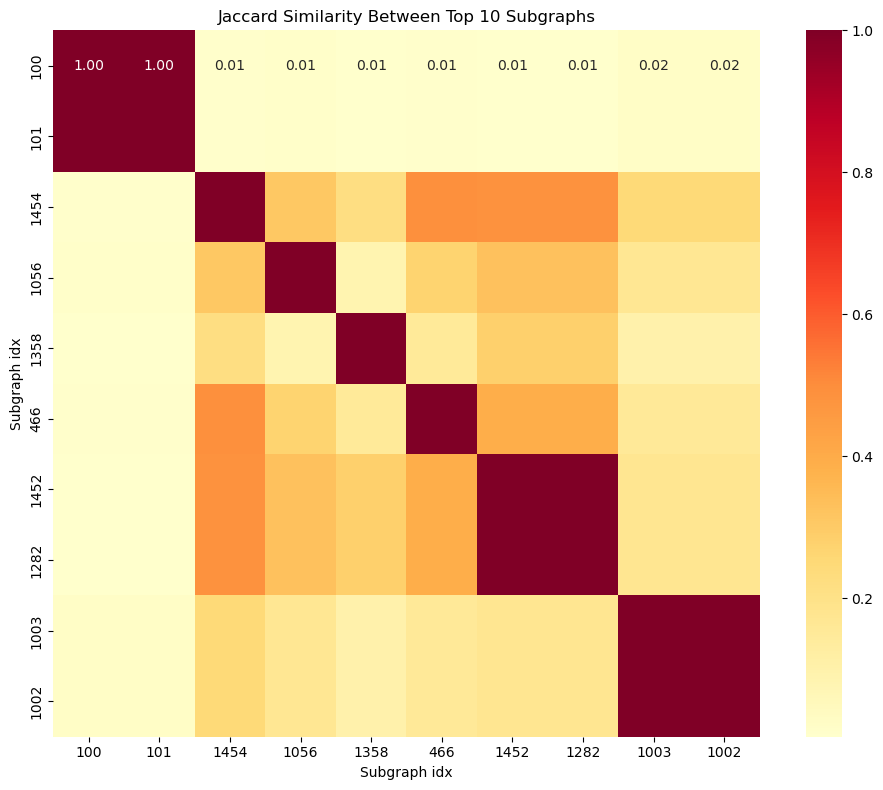

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# 读取 protein_id_with_idx.csv 文件，获取所有子图的 idx
protein_id_with_idx = pd.read_csv('result_save/gnn_2025-03-14-18-49-10/GNNExplainer/most_importance_score_with_idx.csv')
protein_idx = list(protein_id_with_idx['idx'].values)

# 初始化字典存储每个子图的蛋白名
idx_to_proteins = {}

# 读取每个子图的蛋白名并存储
for idx in protein_idx[:10]:  # 这里读取前10个子图，或者你可以根据需要调整
    protein_file = f'result_save/gnn_2025-03-14-18-49-10/GNNExplainer/node_{idx}/protein_name_{idx}_only.csv'
    try:
        proteins = pd.read_csv(protein_file)['Protein_Name'].dropna().tolist()
        idx_to_proteins[idx] = set(proteins)
    except Exception as e:
        print(f"读取 {protein_file} 出错: {e}")

# 创建 Jaccard 相似度矩阵
idx_list = list(idx_to_proteins.keys())
overlap_matrix = pd.DataFrame(index=idx_list, columns=idx_list, dtype=float)

for i in idx_list:
    for j in idx_list:
        set_i, set_j = idx_to_proteins[i], idx_to_proteins[j]
        if i == j:
            overlap_matrix.loc[i, j] = 1.0
        else:
            inter = set_i & set_j
            union = set_i | set_j
            jaccard = len(inter) / len(union) if union else 0
            overlap_matrix.loc[i, j] = jaccard

# 画热图
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix.astype(float), cmap="YlOrRd", annot=True, fmt=".2f", square=True)
plt.title("Jaccard Similarity Between Top 10 Subgraphs")
plt.xlabel("Subgraph idx")
plt.ylabel("Subgraph idx")
plt.tight_layout()
plt.savefig("result_save/gnn_2025-03-14-18-49-10/GNNExplainer/subgraph_jaccard_heatmap_top10.png", dpi=300)
plt.show()

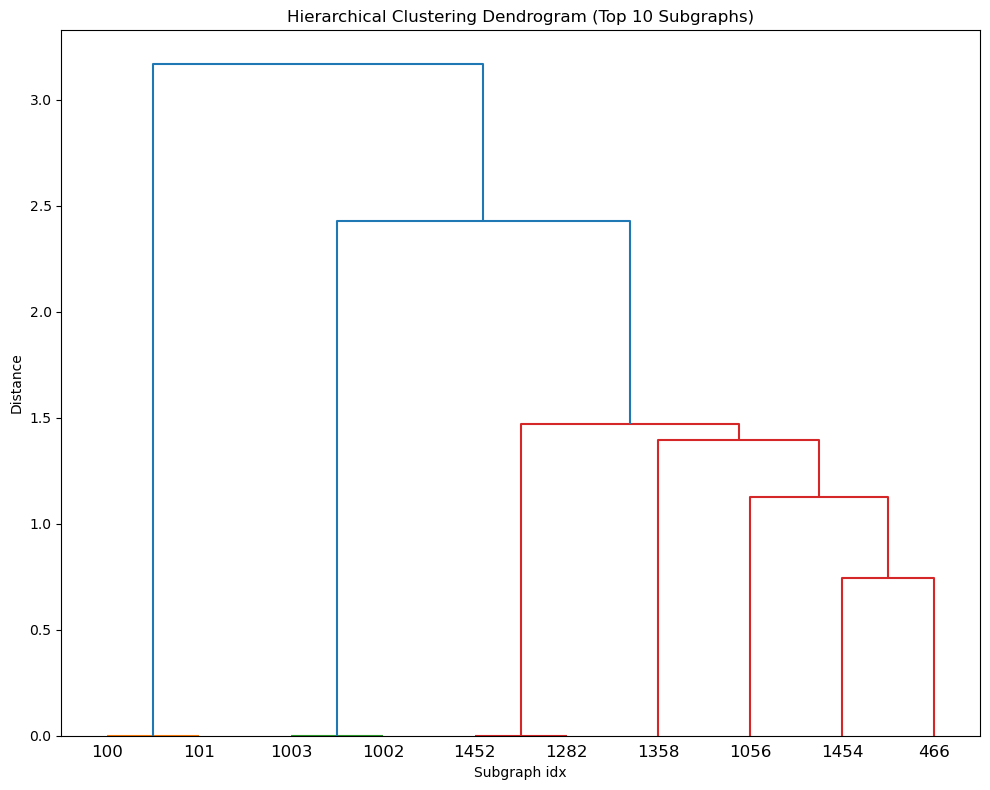

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt

# 使用层次聚类（ward方法）对相似度矩阵进行聚类
Z = linkage(overlap_matrix, method='ward', metric='euclidean')

# 画树状图
plt.figure(figsize=(10, 8))
dendrogram(Z, labels=overlap_matrix.index.tolist(), orientation='top', distance_sort='ascending')
plt.title("Hierarchical Clustering Dendrogram (Top 10 Subgraphs)")
plt.xlabel("Subgraph idx")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig("result_save/gnn_2025-03-14-18-49-10/GNNExplainer/subgraph_hierarchical_dendrogram_top10.png", dpi=300)
plt.show()

In [8]:
import pandas as pd

# ===== 参数设置 =====
input_file = 'result_save\gnn_2025-03-14-18-49-10\GNNExplainer\enrich_conclude_3.tsv'  # 替换为你的文件路径
top_n = 10                     # 提取出现次数最多的前 N 个通路

# ===== 读取并解析文件 =====
data_blocks = []
with open(input_file, 'r', encoding='utf-8') as f:
    node_idx = None
    headers = None
    rows = []

    for line in f:
        line = line.strip()
        if line.startswith('# node_idx:'):
            if node_idx is not None and headers and rows:
                # 保存前一个块
                df = pd.DataFrame(rows, columns=headers)
                df['node_idx'] = node_idx
                data_blocks.append(df)
                rows = []

            # 获取新的 node_idx
            node_idx = int(line.split(':')[1].strip())
        elif line.startswith('category') and '\t' in line:
            headers = line.split('\t')
        elif headers and line:
            rows.append(line.split('\t'))

    # 添加最后一个块
    if node_idx is not None and headers and rows:
        df = pd.DataFrame(rows, columns=headers)
        df['node_idx'] = node_idx
        data_blocks.append(df)

# ===== 合并所有子图数据为一个 DataFrame =====
full_df = pd.concat(data_blocks, ignore_index=True)

# ===== 数据预处理：转换数值列 =====
full_df['GeneRatio_numeric'] = full_df['GeneRatio'].apply(
    lambda x: int(x.split('/')[0]) / int(x.split('/')[1])
)
full_df['pvalue'] = pd.to_numeric(full_df['pvalue'], errors='coerce')

# ===== 找出最常出现的通路 =====
id_counts = (
    full_df.groupby('ID')['node_idx']
    .nunique()
    .reset_index(name='module_count')
    .sort_values(by='module_count', ascending=False)
)

top_ids = id_counts.head(top_n)['ID'].tolist()

# ===== 提取高频通路并排序 =====
top_pathways_df = full_df[full_df['ID'].isin(top_ids)]
top_pathways_df_sorted = top_pathways_df.sort_values(
    by=['pvalue', 'GeneRatio_numeric'],
    ascending=[True, False]
)

# ===== 输出结果 =====
print("\nTop Pathways Across Modules (Sorted by p-value and GeneRatio):\n")
print(top_pathways_df_sorted[['node_idx', 'ID', 'Description', 'pvalue', 'GeneRatio', 'GeneRatio_numeric']])



Top Pathways Across Modules (Sorted by p-value and GeneRatio):

      node_idx        ID                             Description  \
1928      1452  hsa04151              PI3K-Akt signaling pathway   
2079      1282  hsa04151              PI3K-Akt signaling pathway   
405       1056  hsa04060  Cytokine-cytokine receptor interaction   
1247      1316  hsa04151              PI3K-Akt signaling pathway   
1793      1472  hsa04151              PI3K-Akt signaling pathway   
...        ...       ...                                     ...   
565       1508  hsa05135                      Yersinia infection   
74        1003  hsa04917             Prolactin signaling pathway   
158       1002  hsa04917             Prolactin signaling pathway   
830        489  hsa04066                 HIF-1 signaling pathway   
831        489  hsa05145                           Toxoplasmosis   

            pvalue GeneRatio  GeneRatio_numeric  
1928  3.629929e-21    60/354           0.169492  
2079  3.629929e-21

In [9]:
top_pathways_unique = top_pathways_df_sorted[['category', 'subcategory', 'ID', 'Description']].drop_duplicates()

In [10]:
top_pathways_unique

,category,subcategory,ID,Description
1928,Environmental Information Processing,Signal transduction,hsa04151,PI3K-Akt signaling pathway
405,Environmental Information Processing,Signaling molecules and interaction,hsa04060,Cytokine-cytokine receptor interaction
1934,Environmental Information Processing,Signal transduction,hsa04068,FoxO signaling pathway
998,Human Diseases,Infectious disease: parasitic,hsa05142,Chagas disease
841,Environmental Information Processing,Signal transduction,hsa04371,Apelin signaling pathway
292,Human Diseases,Endocrine and metabolic disease,hsa04933,AGE-RAGE signaling pathway in diabetic complic...
597,Human Diseases,Infectious disease: bacterial,hsa05135,Yersinia infection
4,Environmental Information Processing,Signal transduction,hsa04066,HIF-1 signaling pathway
195,Organismal Systems,Endocrine system,hsa04917,Prolactin signaling pathway
209,Human Diseases,Infectious disease: parasitic,hsa05145,Toxoplasmosis


In [11]:
import pandas as pd
import re
from collections import Counter

# ===== 参数设置 =====
input_file = 'result_save\gnn_2025-03-14-18-49-10\GNNExplainer\enrich_conclude_BP_3.tsv'
top_n = 30  # 你想保留的高频通路数

# ===== 辅助函数 =====
def parse_blocks_with_header(filename):
    with open(filename, 'r') as f:
        content = f.read()
    blocks = re.split(r'# node_idx: \d+', content)
    all_dfs = []

    for block in blocks:
        lines = block.strip().splitlines()
        if len(lines) < 2:
            continue
        header = lines[0].strip().split('\t')
        data = [line.strip().split('\t') for line in lines[1:]]
        df = pd.DataFrame(data, columns=header)
        df['GeneRatio_numeric'] = df['GeneRatio'].apply(lambda x: eval(x) if '/' in x else float(x))
        df['Count'] = pd.to_numeric(df['Count'], errors='coerce')
        df['pvalue'] = pd.to_numeric(df['pvalue'], errors='coerce')
        all_dfs.append(df)

    return all_dfs

# ===== 解析所有模块数据 =====
dfs = parse_blocks_with_header(input_file)
all_df = pd.concat(dfs, ignore_index=True)

# ===== 统计出现次数 =====
pathway_counter = Counter(all_df['ID'])
top_pathway_ids = [p for p, _ in pathway_counter.most_common(top_n)]

# ===== 筛选出高频通路并排序 =====
top_pathways_df = all_df[all_df['ID'].isin(top_pathway_ids)].copy()
top_pathways_df['GeneRatio_numeric'] = top_pathways_df['GeneRatio'].apply(lambda x: eval(x))
top_pathways_df['pvalue'] = pd.to_numeric(top_pathways_df['pvalue'], errors='coerce')

# ===== 排序：先按ID出现频率，再按pvalue和GeneRatio =====
top_pathways_df['freq'] = top_pathways_df['ID'].map(pathway_counter)
top_pathways_df_sorted = top_pathways_df.sort_values(by=['freq', 'pvalue', 'GeneRatio_numeric'], ascending=[False, True, False])

# ===== 提取并去重 =====
top_pathways_unique = top_pathways_df_sorted[['ID','Description']].drop_duplicates().head(10)

# ===== 输出查看 =====
top_pathways_unique.to_csv('result_save\gnn_2025-03-14-18-49-10\GNNExplainer\enrich_share_BP_1.tsv',index=False,sep='\t')